# reference
https://en.wikipedia.org/wiki/Total_variation_denoising
https://arxiv.org/pdf/1508.06576v2.pdf

rain
https://afremov.com/mysterious-rain-princess.html

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from six.moves import cPickle
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import xavier_initializer
import shutil
% matplotlib inline

from PIL import Image
import scipy.misc

# load img

content_img size: (1019, 1440)
style_img size: (1059, 1061)


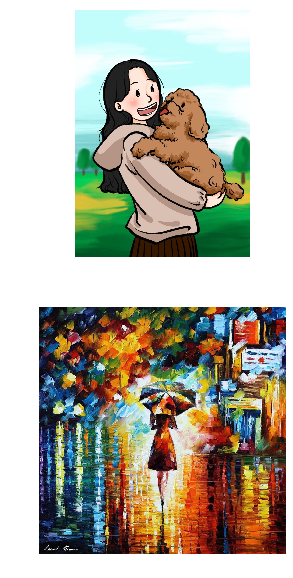

In [2]:
content_list = ["abathur.jpg", "kwangho.jpg", "bigmac.jpg", "simlove1.jpg", 'simlove2.jpg', 'simlove3.jpg', 'scream.jpg']
style_list = ["neon.jpg", "RAIN_PRINCESS.jpg", "simlove1.jpg", "sun_tree.jpg", "sun_tree2.jpg", "getty_large.jpg", 'scream.jpg']

content_name = content_list[3]
style_name = style_list[1]

content_img = Image.open("./data/" + content_name)
style_img = Image.open("./data/" + style_name)


fig, axs = plt.subplots(2, 1, figsize = (15, 10))
axs[0].imshow(content_img)
axs[0].axis('off')
print("content_img size: {}".format(content_img.size))
axs[1].imshow(style_img)
axs[1].axis('off')
print("style_img size: {}".format(style_img.size))
plt.show()

# resize(optional)

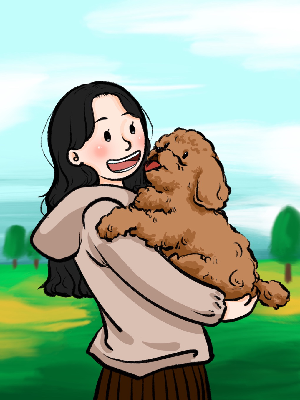

In [3]:
content_img = content_img.resize((300, 400))
content_img

In [4]:
style_img = style_img.resize((300, 380))
style_img

# content, style reshape (batch, height, width, channels)

In [5]:
content_img = np.array(content_img)
content_img = content_img.reshape((1,) + content_img.shape).astype('float32')

style_img = np.array(style_img)
style_img = style_img.reshape((1,) + style_img.shape).astype('float32')

In [6]:
print(content_img.shape)
print(style_img.shape)

(1, 400, 300, 3)
(1, 380, 300, 3)


# build vgg net

In [7]:
vgg_w = cPickle.load(open('./data/vgg19_weights.pkl', 'rb'))
vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
vgg_w.keys()

dict_keys(['conv5_3', 'conv4_4', 'conv4_2', 'conv3_1', 'conv2_1', 'conv5_2', 'conv1_1', 'conv4_1', 'conv3_4', 'conv5_4', 'conv3_2', 'conv1_2', 'conv2_2', 'conv3_3', 'conv5_1', 'conv4_3'])

In [8]:
def vgg_process(img, mean_px, tp):
    if tp == 'pre':
        return (img - mean_px).astype("float32")
    elif tp == 'post':
        return (img + mean_px).astype("float32")

In [9]:
# vgg net base

def vgg_net(tensor, vgg_w):    
    layers = [
        'conv1_1', 'relu1_1', 'conv1_2', 'relu1_2', 'pool1',

        'conv2_1', 'relu2_1', 'conv2_2', 'relu2_2', 'pool2',

        'conv3_1', 'relu3_1', 'conv3_2', 'relu3_2', 'conv3_3',
        'relu3_3', 'conv3_4', 'relu3_4', 'pool3',

        'conv4_1', 'relu4_1', 'conv4_2', 'relu4_2', 'conv4_3',
        'relu4_3', 'conv4_4', 'relu4_4', 'pool4',

        'conv5_1', 'relu5_1', 'conv5_2', 'relu5_2', 'conv5_3',
        'relu5_3', 'conv5_4', 'relu5_4'
        
    ]
    
    net = {}
    
    for layer in layers:
        if layer[:4] == 'conv':
            tensor = tf.nn.conv2d(tensor, tf.constant(vgg_w[layer][0]), strides=[1,1,1,1], 
                                 padding="SAME")
            tensor = tensor + vgg_w[layer][1]
        elif layer[:4] == 'relu':
            tensor = tf.nn.relu(tensor)
        elif layer[:4] == 'pool':
            tensor = tf.nn.max_pool(tensor, ksize=[1,2,2,1], strides= [1,2,2,1],
                                   padding="SAME")
        net[layer] = tensor

    return net

# build style transfer

In [10]:
def tensor_size(tensor):
    from operator import mul
    from functools import reduce
    return reduce(mul, (t.value for t in tensor.shape), 1)

## calculate style and content

In [11]:
# content_layers = ['conv1_1', 'conv2_1', 'conv4_1', 'conv4_2', 'conv5_1', 'conv5_2']
content_layers = ['relu4_2']
style_layers = ['conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
# style_layers = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1']

content_features = {}
style_features = {}
with tf.Session() as sess:
    c_pre = vgg_process(content_img, vgg_mean, 'pre')
    c_net = vgg_net(c_pre, vgg_w)
    for layer in content_layers:
        content_features[layer] = c_net[layer].eval()

    s_pre = vgg_process(style_img, vgg_mean, 'pre')
    s_net = vgg_net(s_pre, vgg_w)
    for layer in style_layers:
        feature = s_net[layer]        
        feature = tf.reshape(feature, [-1, feature.shape[3]])
        feature_size = tensor_size(feature)
        
        gram = tf.matmul(tf.transpose(feature), feature) / feature_size
        style_features[layer] = gram.eval()

## make output

In [12]:
initial_img = False # initail_img.shape must equal to content_img.shape
output = None

if initial_img:
    output = tf.Variable(initial_value = vgg_process(content_img, vgg_mean, 'pre'))
else:
    output = tf.Variable(tf.random_normal(content_img.shape, stddev=0.1))

output_net = vgg_net(output, vgg_w)

# initialize hyper parameters

In [13]:
content_weight = 2e8
style_weight = 8e7
noise_weight = 2e10
LR = 1
n_iter = 10000
n_prt = 1000
n_save = 100

## content loss

In [14]:
loss_content = 0
for layer in content_layers:
    content_size = tensor_size(output)
    loss = tf.nn.l2_loss((output_net[layer] - content_features[layer]) / 
                         content_features[layer].size)
    loss_content += loss
loss_content = content_weight*loss_content

## style loss

In [15]:
loss_style = 0
for layer in style_layers:
    output_feature = output_net[layer]
    output_feature = tf.reshape(output_feature, [-1, output_feature.shape[3]])
    feature_size = tensor_size(output_feature)
    
    gram = tf.matmul(tf.transpose(output_feature), output_feature) / feature_size
    loss = tf.nn.l2_loss((gram - style_features[layer]) / style_features[layer].size)
    
    loss_style += loss
loss_style = style_weight*loss_style

## noise loss

In [16]:
noise_x = output[:, 1:, :, :] - output[:, :-1, :, :]
noise_x = tf.nn.l2_loss(noise_x / tensor_size(noise_x))

noise_y = output[:, :, 1:, :] - output[:, :, :-1, :]
noise_y = tf.nn.l2_loss(noise_y / tensor_size(noise_y))

loss_noise = noise_weight*(noise_x + noise_y)

## total loss

In [17]:
loss_total = loss_content + loss_style + loss_noise

# train

In [18]:
optm = tf.train.AdamOptimizer(LR).minimize(loss_total)
init = tf.global_variables_initializer()

Iter 0/10000
Loss content : 84834520.0
Loss Style :   6109343744.0
Loss Noise :   61520.68359375
Loss Total :   6194239488.0


C:\Users\KH_Home\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


Iter 1000/10000
Loss content : 74786184.0
Loss Style :   20815074.0
Loss Noise :   38622020.0
Loss Total :   134223280.0


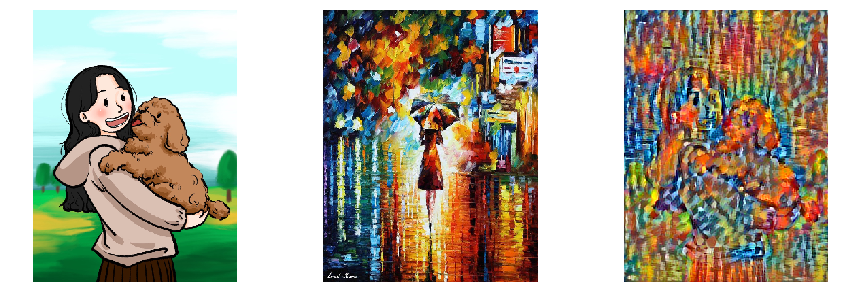

Iter 2000/10000
Loss content : 65518296.0
Loss Style :   12742630.0
Loss Noise :   35452748.0
Loss Total :   113713680.0


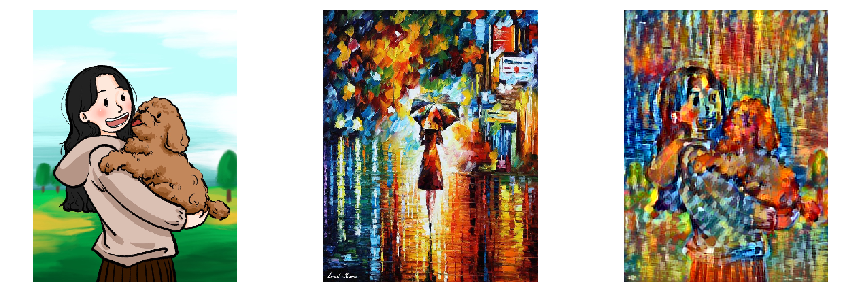

Iter 3000/10000
Loss content : 61834704.0
Loss Style :   9897622.0
Loss Noise :   34486412.0
Loss Total :   106218736.0


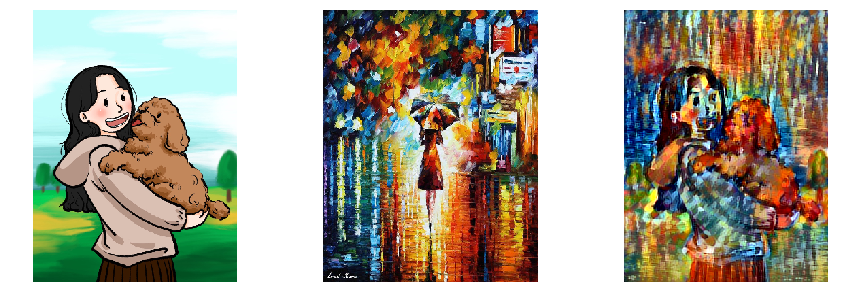

Iter 4000/10000
Loss content : 59966456.0
Loss Style :   8924789.0
Loss Noise :   34076664.0
Loss Total :   102967912.0


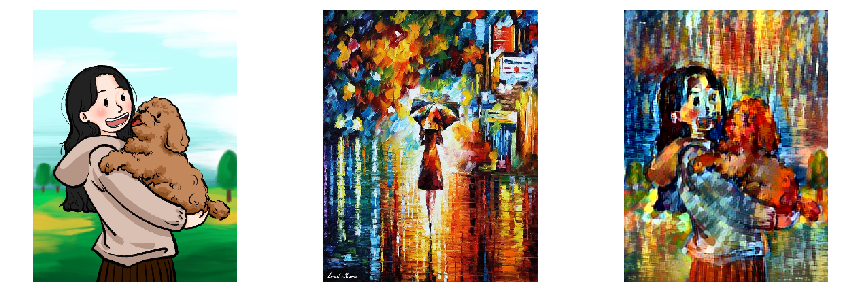

Iter 5000/10000
Loss content : 58951640.0
Loss Style :   8666086.0
Loss Noise :   33843052.0
Loss Total :   101460784.0


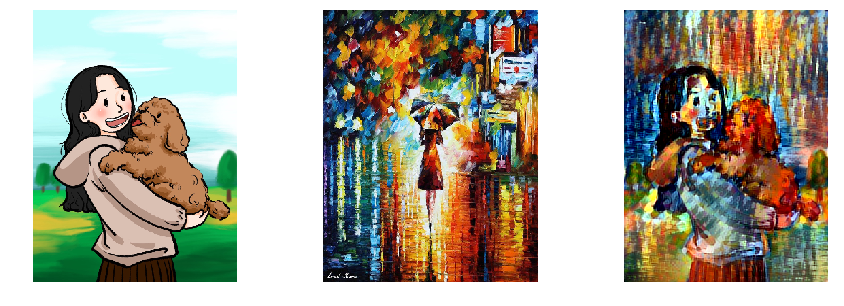

Iter 6000/10000
Loss content : 58392340.0
Loss Style :   8729255.0
Loss Noise :   33726476.0
Loss Total :   100848064.0


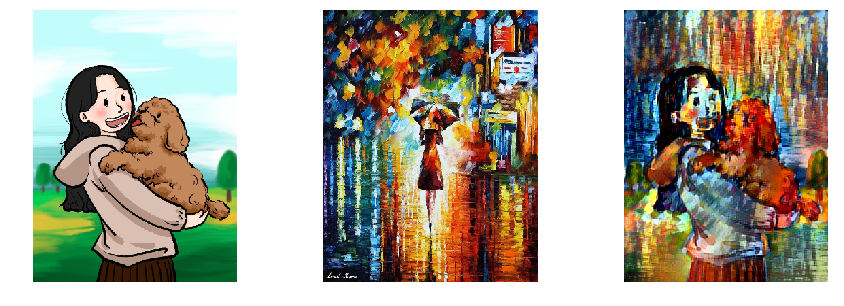

Iter 7000/10000
Loss content : 57902836.0
Loss Style :   8582798.0
Loss Noise :   33630412.0
Loss Total :   100116048.0


Iter 8000/10000
Loss content : 57584656.0
Loss Style :   8880026.0
Loss Noise :   33556604.0
Loss Total :   100021280.0


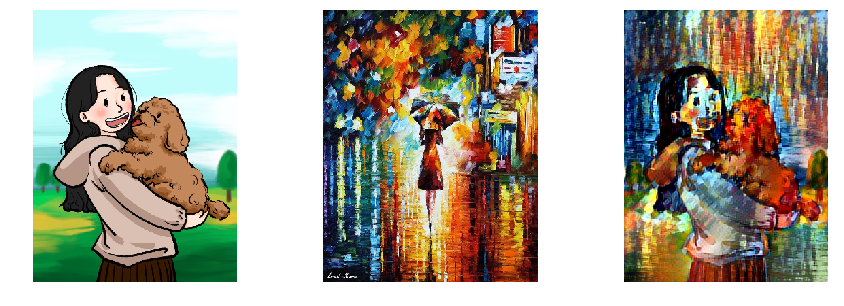

Iter 9000/10000
Loss content : 57412756.0
Loss Style :   8570042.0
Loss Noise :   33525158.0
Loss Total :   99507960.0


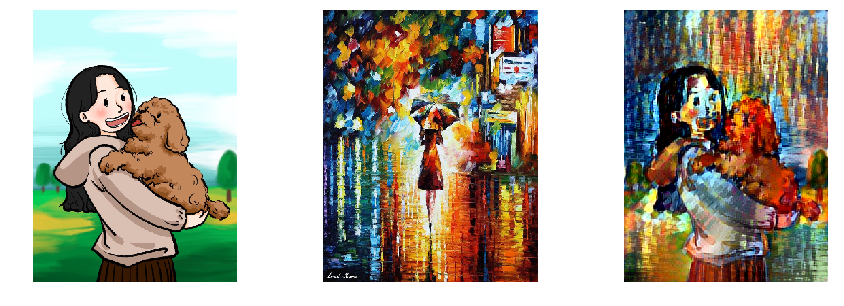

Iter 10000/10000
Loss content : 57311988.0
Loss Style :   8562546.0
Loss Noise :   33493566.0
Loss Total :   99368104.0


In [19]:
min_loss = 1e10

from time import gmtime

cur_time = gmtime()
cur_time = str(cur_time.tm_hour) + str(cur_time.tm_min) + str(cur_time.tm_sec) 

with tf.Session() as sess:
    sess.run(init)
    for i in range(n_iter+1):
        sess.run(optm)
        
        if i % n_prt == 0:
            lc = sess.run(loss_content)
            ls = sess.run(loss_style)
            ln = sess.run(loss_noise)
            lt = sess.run(loss_total)
            print("Iter {}/{}".format(i, n_iter))
            print("Loss content : {}".format(lc))
            print("Loss Style :   {}".format(ls))
            print("Loss Noise :   {}".format(ln))
            print("Loss Total :   {}".format(lt))
            
            fig, axs = plt.subplots(1, 3, figsize = (15, 5))
            axs[0].imshow(content_img[0].astype(np.uint8))
            axs[0].axis('off')
            axs[1].imshow(style_img[0].astype(np.uint8))
            axs[1].axis('off')
            my_output = sess.run(output)
            my_output = vgg_process(my_output, vgg_mean, 'post')
            my_output = np.clip(my_output[0], 0, 255).astype(np.uint8)
            axs[2].imshow(my_output)
            axs[2].axis('off')
            plt.show()
            
            if lt <= min_loss:
                min_loss = lt
                scipy.misc.imsave('./data/output_output_{0}_{1}_{2}.jpg'.format(content_name[:-4],
                                                                             style_name[:-4],
                                                                             cur_time), my_output)

# debug

In [20]:
output_img = Image.open('./data/output_output_{0}_{1}_{2}.jpg'.format(content_name[:-4], 
                                                                      style_name[:-4], 
                                                                      cur_time))
output_img